# Perform an Adversarial attack.

For the second part of the project we consider a trained model (MobileNet) which is trained on the imagenet dataset. 

We use an evasion attack called [FGSM](https://neptune.ai/blog/adversarial-attacks-on-neural-networks-exploring-the-fast-gradient-sign-method#:~:text=The%20Fast%20Gradient%20Sign%20Method%20(FGSM)%20combines%20a%20white%20box,model%20into%20making%20wrong%20predictions.) to fool the neural network into making incorrect predictions.

## Import Packages.

Import the necessary packages we continue to use Tensorflow and Keras

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from keras.preprocessing import image
from google.colab import data_table
data_table.enable_dataframe_formatter()
device_name = tf.test.gpu_device_name()
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

## Load the Pretrained model. 

We use the [MobileNetV2](https://arxiv.org/abs/1801.04381) model trained on the [Imagenet](https://www.image-net.org/) dataset. 

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14548992/14536120 [==============================] - 0s 0us/step


### Helper Function for Data Processing


Following functions can be used for data processing. Dont worry about these, just use them. 

In [ ]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image, size):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (size, size))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Load an Image. 


Load any image, we consider an image of a Golden Retriever. 

In [ ]:
image_raw = tf.io.read_file('/content/orca.jpeg')
image = tf.image.decode_image(image_raw)

image = preprocess(image, 224)
image_probs = pretrained_model.predict(image)

49152/35363 [=========================================] - 0s 0us/step


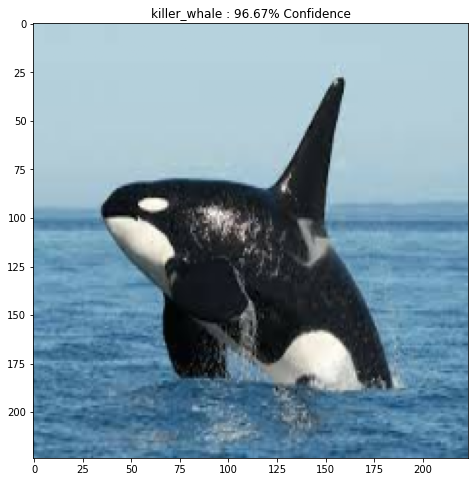

In [ ]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the Adversarial Image. 

We use the FGSM method to create an adversarial image. Be sure to read about FGSM to understand how the attack works. 

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label, model):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

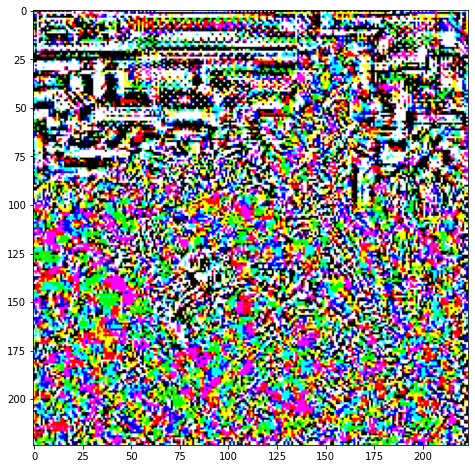

In [ ]:
# Get the input label of the image.
killer_whale_index = 148
label = tf.one_hot(killer_whale_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label, pretrained_model)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [ ]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

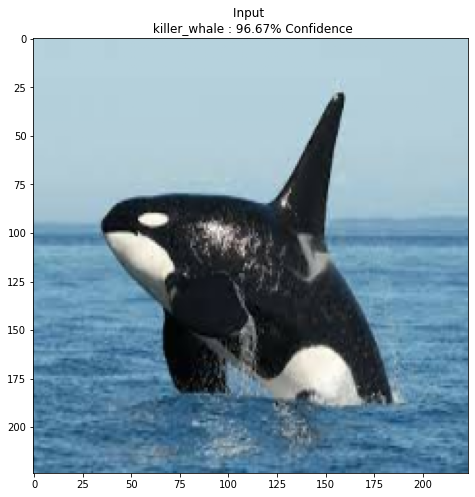

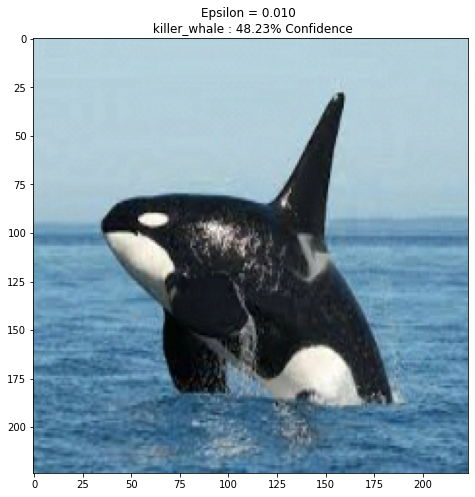

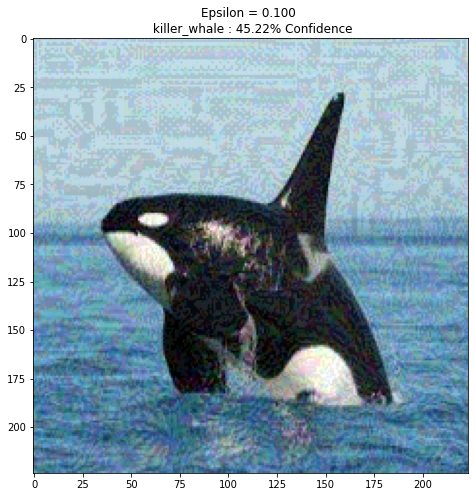

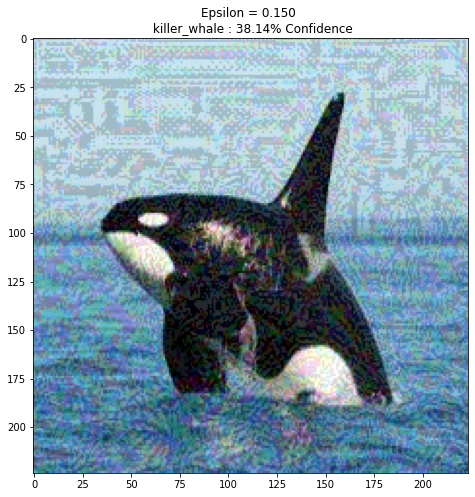

In [ ]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

# Task2: Perform an Analysis to understand the potency of the attack. 

Your task here is to understand how small a change could change the class output and this is measured by the epsilon value needed to change the class. 

Your task is as follows:

* Pick 10 images each from different classes in imagenet. 
* Perform a perturbation analysis on each of these images. 
* In the analysis you are required to report the smallest epsilon value for which you notice a class change. 
* Make a table for each of the images considered with the minimum epsilon value for the FGSM attack. 

Write the Code for the above below. You can add the table also below. 

In [ ]:
imageNames = ["bee", "pillow", "schoolbus", "ambulance", "llama", "park_bench", "soda_bottle","toaster", "banana", "cab"]
image_labels = [309, 721, 779,407, 355, 703, 737, 859, 954, 468]

def findEps(image, input_label,model ):
  searchSpace = np.linspace(0,2,2001)
  start = 0;
  end = len(searchSpace) - 1;
  ans = -1;
  perturbations = create_adversarial_pattern(image, input_label, model)
  _, OG_images_class, OG_class_confidence = get_imagenet_label(model.predict(image))
  while (start <= end):
      mid = (start + end) // 2;
      #check the current one
      currentImage = image + searchSpace[mid]*perturbations
      _, images_class, class_confidence = get_imagenet_label(model.predict(currentImage))
      # Move to right side if image is the same.
      if (images_class == OG_images_class):
          start = mid + 1;
          
      # Move left side.
      else:
          ans = mid;
          end = mid - 1;
  return searchSpace[ans]


In [ ]:
###NOTE WE CAP NOISE TESTING at EPSILON = 2 HERE
def task_two(model, input_size):
  images_raw = [];
  decodedimages = [];
  images = [];
  images_probs = [];
  images_class = [];
  classes_confidence = [];
  epsThreshold = [];
  for i,name in enumerate(imageNames):
    fullName = "/content/" + name + ".jpeg"
    images_raw.append(tf.io.read_file(fullName))
    decodedimages.append(tf.image.decode_image(images_raw[i]))
    images.append(preprocess(decodedimages[i], input_size ))
    images_probs.append(model.predict(images[i]))
    _, image_class, class_confidence = get_imagenet_label(images_probs[i])
    images_class.append(image_class)
    classes_confidence.append(classes_confidence)
    label = tf.one_hot(image_labels[i], images_probs[i].shape[-1])
    label = tf.reshape(label, (1, images_probs[i].shape[-1]))
    epsThreshold.append(findEps(images[i], label, model))
  data = [imageNames, epsThreshold]
  return data



  

In [ ]:
#RUN TASK 2
tableA = task_two(pretrained_model, 224)
print("Minimum Epsilon Values for MobileNetV2 (Task2):")
print(tabulate(tableA))

Minimum Epsilon Values for MobileNetV2 (Task2):
-----  ------  ---------  ---------  -----  ----------  -----------  -------  ------  -----
bee    pillow  schoolbus  ambulance  llama  park_bench  soda_bottle  toaster  banana  cab
0.132  0.061   0.001      0.001      0.005  0.376       0.01         0.135    0.004   0.003
-----  ------  ---------  ---------  -----  ----------  -----------  -------  ------  -----


# Task3: Compare the robustness of the considered model with other models. 

Your task here is to compare how this model (MobileNetV2) compares with other popular object detection models. 

Your task is as follows:

* Consider 5 different models (you can consider various RESNET architectures, any models you find interesting).
* Load the pre-trained weights of the model (trained on imagenet). 
* Perform Task2 on all the considered models. 
* Add all the results in the table. Hence the final table you have 6 columns for each model and epsilon values for each of the 10 images for all 6 models. 


What do you observe? Why do you think this is the case? 

Write the Code for the above below. You can also add the table and answer to the question below. 


In [ ]:
###NOTE WE CAP NOISE TESTING at EPSILON = 2 HERE
def task_three():
  Xception_model = tf.keras.applications.Xception(include_top=True,
                                                     weights='imagenet')
  resnet50_model = tf.keras.applications.ResNet50(include_top=True,
                                                     weights='imagenet')
  vgg_model = tf.keras.applications.VGG16(include_top=True,
                                                     weights='imagenet')
  efficientb0_model = tf.keras.applications.EfficientNetB0(include_top=True,
                                                     weights='imagenet')
  NASNetMobile_model = tf.keras.applications.NASNetMobile(include_top=True,
                                                     weights='imagenet')
  models = [pretrained_model, Xception_model, resnet50_model, vgg_model, efficientb0_model, NASNetMobile_model]
  modelLabels = ["MobileNet_V2", "Xception_Model", "Resnet_50", "VGG16", "EfficientNet_B0","NASNet_Mobile" ]
  inputsizes = [224, 299, 224, 224, 224, 224]
  attackOut = []
  for i, model in enumerate(models):
    model.trainable = False
    attackOut.append([modelLabels[i],(task_two(model,inputsizes[i]))])
  return attackOut


In [ ]:
data = task_three()
for dat in data:
  print("Minimum Epsilon necessary for model: " + dat[0])
  print(tabulate(dat[1]))


Minimum Epsilon necessary for model: MobileNet_V2
-----  ------  ---------  ---------  -----  ----------  -----------  -------  ------  -----
bee    pillow  schoolbus  ambulance  llama  park_bench  soda_bottle  toaster  banana  cab
0.132  0.061   0.001      0.001      0.005  0.376       0.01         0.135    0.004   0.003
-----  ------  ---------  ---------  -----  ----------  -----------  -------  ------  -----
Minimum Epsilon necessary for model: Xception_Model
-----  ------  ---------  ---------  -----  ----------  -----------  -------  ------  -----
bee    pillow  schoolbus  ambulance  llama  park_bench  soda_bottle  toaster  banana  cab
0.005  0.094   0.494      0.456      0.007  0.029       0.298        0.393    0.08    0.001
-----  ------  ---------  ---------  -----  ----------  -----------  -------  ------  -----
Minimum Epsilon necessary for model: Resnet_50
-----  ------  -------------------  ---------  -------------------  -------------------  -----------  -------  ------  

Note that the maximum epsilon value output is 2, a bound for my search. The actual epsilon necessary to reach a misclassification can be higher in some cases but this is not common as can be seen in the data.

It appears the epsilon value necessary for different models varies signficantly and the relative ordering of images does not remain the same between models either. Each model has a different structure with different types of layers and activation functions that cause our perturbation generation to have a different effect instead of being completely deterministic. Further, the data also seems to imply that certain images are much more prone to this attack than others based on the model as well. This implies the robustness of a model with respect to this attack is also based on what the input images are and that certain models are more robust for particular images.

# BONUS: Can you provide a better attack?

Can you design a better attack that lowers the epsilon required for the images?

Task:

* Design another attack. 
* Compare the epsilon values on 10 images. 
* Does it perform better than the FGSM attack? That is, does it have lower epsilon values?

Write the code and provide your answers below. 

No I can't